# Style Transfer
Perfect and complete explanation => [Artistic Style Transfer by Naoki Shibuya](https://github.com/naokishibuya/deep-learning/blob/master/python/artistic_style_transfer.ipynb)
## Libraries

In [0]:
%tensorflow_version 1.x

In [0]:
import warnings; warnings.filterwarnings('ignore')
import urllib,cv2
import numpy as np,tensorflow as tf,pylab as pl,keras as ks
from tqdm import tqdm
fpath='https://olgabelitskaya.github.io/'
style_layers=['block1_conv1','block2_conv1','block3_conv1',
              'block4_conv1','block5_conv1']

## Display Images

In [0]:
def display_images(original,style,fpath=fpath):
    input_file=urllib.request.urlopen(fpath+original)
    output_file=open(original,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    input_file=urllib.request.urlopen(fpath+style)
    output_file=open(style,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    original_img=cv2.imread(original)
    style_img=cv2.imread(style)    
    pl.figure(1,figsize=(12,4))
    pl.subplot(121)
    pl.title("Shape of the original image: %s"%str(original_img.shape))
    pl.imshow(cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB))
    pl.subplot(122)
    pl.title("Shape of the style image: %s"%str(style_img.shape))
    pl.imshow(cv2.cvtColor(style_img,cv2.COLOR_BGR2RGB)); pl.show()

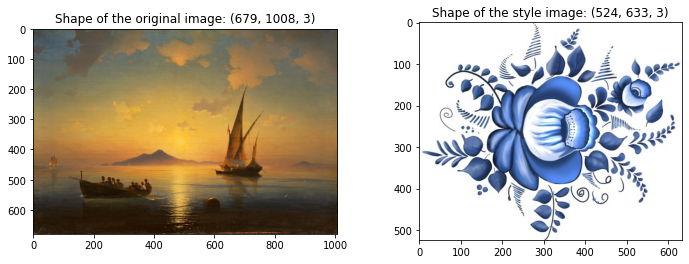

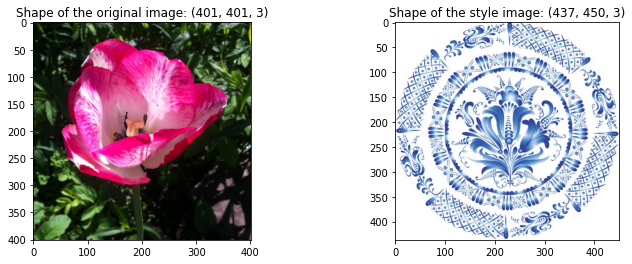

In [21]:
display_images('picture02.png','pattern02.png')
display_images('picture09.png','pattern09.png')

## Preprocessing

In [22]:
picture02=cv2.imread('picture02.png').astype('float32')
pattern02=cv2.imread('pattern02.png').astype('float32')
picture02=cv2.resize(picture02,(633,524))\
.astype('float32')
pattern02=cv2.resize(pattern02,(633,524))\
.astype('float32')
picture02.shape,pattern02.shape

((524, 633, 3), (524, 633, 3))

In [23]:
picture02[1]

array([[104.26471 , 138.8359  , 161.45808 ],
       [ 95.14151 , 124.09227 , 140.55699 ],
       [ 71.99578 ,  92.34139 ,  99.905525],
       ...,
       [ 66.748764,  74.86136 ,  78.41766 ],
       [ 63.392326,  71.94862 ,  73.61752 ],
       [ 60.986298,  69.542595,  71.21149 ]], dtype=float32)

In [0]:
def preprocess(img):
    img=img.copy(); img=np.expand_dims(img,axis=0) 
    return ks.applications.vgg16.preprocess_input(img)

In [0]:
def deprocess(img):
    img=img.copy()[0]                        
    img[:,:,0]+=103.939; img[:,:,1]+=116.779; img[:,:,2]+=123.68             
    img=img[:,:,::-1]              
    img=np.clip(img,0,255)         
    return img.astype('uint8') 

In [0]:
def inputs(original_img,style_img):
    original_input=tf.constant(preprocess(original_img))
    style_input=tf.constant(preprocess(style_img))
    generated_input=tf.placeholder(tf.float32,original_input.shape)
    return original_input,style_input,generated_input

In [27]:
original_input2,style_input2,generated_input2=\
inputs(picture02,pattern02)
input_tensor2=tf.concat([original_input2,style_input2,
                         generated_input2],axis=0)
input_tensor2.shape

TensorShape([Dimension(3), Dimension(524), Dimension(633), Dimension(3)])

## VGG16 Usage

In [28]:
vgg16_model=ks.applications.vgg16.\
VGG16(input_tensor=input_tensor2,include_top=False)
vgg16_layer_dict={layer.name:layer for layer in vgg16_model.layers}
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
def calculate_original_loss(layer_dict,original_layer_names):
    loss=0
    for name in original_layer_names:
        layer=layer_dict[name]
        original_features=layer.output[0,:,:,:]  
        generated_features=layer.output[2,:,:,:] 
        loss+=ks.backend.sum(ks.backend.square(generated_features-original_features))
    return loss/len(original_layer_names)
def gram_matrix(x):    
    features=ks.backend.batch_flatten(ks.backend.permute_dimensions(x,(2,0,1))) 
    gram=ks.backend.dot(features,ks.backend.transpose(features))
    return gram
def get_style_loss(style_features,generated_features,size):
    S=gram_matrix(style_features)
    G=gram_matrix(generated_features)
    channels=3
    return ks.backend.sum(ks.backend.square(S-G))/(4.*(channels**2)*(size**2))
def calculate_style_loss(layer_dict,style_layer_names,size):
    loss=0
    for name in style_layer_names:
        layer=layer_dict[name]
        style_features=layer.output[1,:,:,:] 
        generated_features=layer.output[2,:,:,:] 
        loss+=get_style_loss(style_features,generated_features,size) 
    return loss/len(style_layer_names)
def calculate_variation_loss(x):
    row_diff=ks.backend.square(x[:,:-1,:-1,:]-x[:,1:,:-1,:])
    col_diff=ks.backend.square(x[:,:-1,:-1,:]-x[:,:-1,1:,:])
    return ks.backend.sum(ks.backend.pow(row_diff+col_diff,1.25))

In [0]:
original_loss2=calculate_original_loss(vgg16_layer_dict,['block5_conv2'])
style_loss2=calculate_style_loss(vgg16_layer_dict,style_layers, 
                                 pattern02.shape[0]*pattern02.shape[1])
variation_loss2=calculate_variation_loss(generated_input2)

## Generated Images

In [31]:
loss2=.5*original_loss2+1.*style_loss2+.1*variation_loss2    
gradients2=ks.backend.gradients(loss2,generated_input2)[0]
calculate2=ks.backend.function([generated_input2],[loss2,gradients2])
generated_data2=preprocess(picture02)
for i in tqdm(range(100)):
    _,gradients_value2=calculate2([generated_data2])
    generated_data2-=gradients_value2*.001

100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


In [32]:
loss2=.5*original_loss2+1.*style_loss2+.1*variation_loss2    
gradients2=ks.backend.gradients(loss2,generated_input2)[0]
calculate2=ks.backend.function([generated_input2],[loss2,gradients2])
generated_data22=preprocess(picture02)
for i in tqdm(range(1000)):
    _,gradients_value2=calculate2([generated_data22])
    generated_data22-=gradients_value2*.001

100%|██████████| 1000/1000 [02:49<00:00,  5.88it/s]


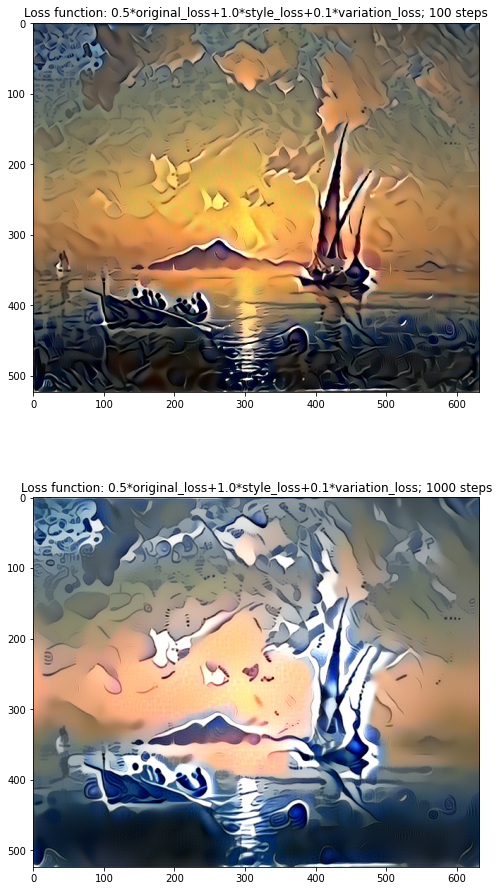

In [33]:
generated_image01=deprocess(generated_data2)
generated_image02=deprocess(generated_data22)
pl.figure(1,figsize=(8,16))
pl.subplot(211)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 100 steps")
pl.imshow(cv2.cvtColor(generated_image01,cv2.COLOR_BGR2RGB))
pl.subplot(212)
pl.title("Loss function: 0.5*original_loss+1.0*style_loss+0.1*variation_loss; 1000 steps")
pl.imshow(cv2.cvtColor(generated_image02,cv2.COLOR_BGR2RGB))
pl.show()

In [0]:
#numpy.save('generated_data2.npy',generated_data2)
#numpy.save('generated_data22.npy',generated_data21)